<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/zindi/trailblaers_open2all/notebooks/00_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import gc
import os
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.set_printoptions(precision=4)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

from google.colab import drive
from google.colab.output import eval_js

SEED = 23
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [170]:
DATA_PATH = '/content/drive/MyDrive/data_science_competitions/zindi/trailblazers_open2all/data'
SUBMISSION_PATH = '/content/drive/MyDrive/data_science_competitions/zindi/trailblazers_open2all/submissions'

In [171]:
train = pd.read_csv(f'{DATA_PATH}/raw/train.csv')
test = pd.read_csv(f'{DATA_PATH}/raw/test.csv')
sample_sub = pd.read_csv(f'{DATA_PATH}/raw/sample_sub.csv')

# Data overview

In [172]:
train.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.0000,60.2,0.0080,18.5168,1.9964,-1.2274,7.3830e-05,0.0002,-1.2313,0.0065,840209.8746,76.5375,38.6343,-61.7367,22.3582,5.6793e-05,6156.0742,1.7038e-05,0.1191,234.1511,0.0000,76.5364,38.5930,-61.7526,22.3637,0.0211,883.3325,267.0172,840138.4611,74.5434,38.6225,-61.7890,22.3791,-1.0413e-05,0.0000,76.5364,38.5930,-61.7526,22.3637,6.3888e-05,0.5668,NaN,NaN,0.0000,NaN,NaN,NaN,76.5364,38.5930,-61.7526,22.3637,NaN,-1.2313,840209.8746,76.5375,38.6343,-61.7367,22.3582,-0.0001,0.3125,-4.0466e-05,-1.8615,0.0000,76.5364,38.5930,-61.7526,22.3637,1793.7936,3227.8555,0.0106,74.481,37.5015,-62.1426,22.5451
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.6000,48.8,0.0084,22.5465,3.3304,-1.1881,7.6033e-05,0.0002,-1.0826,0.0184,840772.9420,-14.7080,59.6249,-67.6935,28.6148,5.4651e-05,6156.0742,2.1381e-05,0.1152,233.3137,0.0594,-14.7080,59.6249,-67.6935,28.6148,0.0220,1148.9854,61.2167,841116.7631,-57.0152,61.4026,-74.4576,33.0895,1.1445e-04,0.0594,-14.7080,59.6249,-67.6935,28.6148,1.7099e-04,0.8584,175.0199,99354.1630,0.0594,5.9585,175.0721,99353.6724,-14.7080,59.6249,-67.6935,28.6148,0.3154,-1.0826,840772.9420,-14.7080,59.6249,-67.6935,28.6148,0.0002,0.4340,5.0211e-05,-1.4526,0.0594,-14.7080,59.6249,-67.6935,28.6148,1789.9604,3384.2266,0.0151,75.630,55.6575,-53.8681,19.2937
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.4000,33.4,0.0075,27.0310,5.0657,3.5006,6.6608e-05,0.0002,-1.0012,0.0159,841410.7135,-105.2013,49.8397,-78.3427,34.2970,5.9126e-05,7311.8691,7.4820e-06,0.1159,232.2335,0.0821,-105.2013,49.8397,-78.3427,34.2970,0.0207,1109.3471,134.7003,841319.8604,-103.4945,49.

In [173]:
test.head()

,Place_ID X Date,Date,Place_ID,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,0OS9LVX X 2020-01-02,2020-01-02,0OS9LVX,11.6000,30.2,0.0041,14.6568,3.9564,0.7126,5.3382e-05,0.0001,0.4662,0.0108,835670.4927,68.0994,1.4457,-95.9850,22.9420,4.5906e-05,6156.0742,7.4754e-06,0.1133,227.4675,0.0321,68.0994,1.4457,-95.9850,22.9420,0.0180,841.1429,155.9830,835625.7853,32.7097,1.8981,-95.9870,22.9501,7.3011e-05,0.0321,68.0994,1.4457,-95.9850,22.9420,8.8257e-05,1.4940,2592.6342,74028.4292,0.0323,6.3175,2593.1374,74023.9307,68.0994,1.4457,-95.9850,22.9420,0.2991,0.4662,835670.4927,68.0994,1.4457,-95.9850,22.9420,2.2071e-04,0.7844,1.8359e-04,-0.1405,0.0321,68.0994,1.4457,-95.9850,22.9420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0OS9LVX X 2020-01-03,2020-01-03,0OS9LVX,18.3000,42.9,0.0059,15.0265,4.2304,0.6619,5.0448e-05,0.0001,-0.2137,0.0283,835281.8828,75.9368,34.6389,-95.0180,18.5395,4.5071e-05,7311.8691,5.3004e-06,0.1104,227.7887,0.0448,75.9368,34.6392,-95.0176,18.5395,0.0196,1187.5703,922.3858,835225.2783,73.8081,34.7209,-95.0171,18.5486,4.8393e-05,0.0408,75.9368,34.6418,-95.0149,18.5391,7.4462e-05,1.5345,7334.6011,48466.6533,0.0462,8.3084,7902.9375,46345.6130,75.9368,34.6392,-95.0176,18.5395,0.2904,-0.2137,835281.8828,75.9368,34.6389,-95.0180,18.5395,3.3869e-05,0.6790,1.3535e-05,-0.8427,0.0408,75.9368,34.6418,-95.0149,18.5391,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0OS9LVX X 2020-01-04,2020-01-04,0OS9LVX,17.6000,41.3,0.0059,15.5110,5.2457,1.6406,5.0354e-05,0.0001,-0.2543,0.0104,834839.0508,75.5524,55.8723,-94.0154,14.1408,4.4056e-05,6156.0742,6.2976e-06,0.1125,229.2356,0.0071,75.5524,55.8723,-94.0154,14.1408,0.0187,944.3414,1281.8921,834751.9873,73.8617,56.0198,-94.0014,14.1440,6.1130e-06,0.0071,75.5524,55.8723,-94.0154,14.1408,4.2094e-05,1.6805,5188.5241,61477.2919,0.0078,6.4155,5797.7422,57757.8422,75.5524,55.8723,-94.0154,14.1408,

In [174]:
sample_sub.head()

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,0
1,0OS9LVX X 2020-01-03,0
2,0OS9LVX X 2020-01-04,0
3,0OS9LVX X 2020-01-05,0
4,0OS9LVX X 2020-01-06,0


In [175]:
eval_js('google.colab.output.setIframeHeight("300")')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 82 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      30557 non-null  object 
 1   Date                                                 30557 non-null  object 
 2   Place_ID                                             30557 non-null  object 
 3   target                                               30557 non-null  float64
 4   target_min                                           30557 non-null  float64
 5   target_max                                           30557 non-null  float64
 6   target_variance                                      30557 non-null  float64
 7   target_count                                         30557 non-null  int64  
 8   precipitable_water_entire_atmosphere                 30557 non-nul

In [176]:
eval_js('google.colab.output.setIframeHeight("300")')

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16136 entries, 0 to 16135
Data columns (total 77 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      16136 non-null  object 
 1   Date                                                 16136 non-null  object 
 2   Place_ID                                             16136 non-null  object 
 3   precipitable_water_entire_atmosphere                 16136 non-null  float64
 4   relative_humidity_2m_above_ground                    16136 non-null  float64
 5   specific_humidity_2m_above_ground                    16136 non-null  float64
 6   temperature_2m_above_ground                          16136 non-null  float64
 7   u_component_of_wind_10m_above_ground                 16136 non-null  float64
 8   v_component_of_wind_10m_above_ground                 16136 non-nul

In [177]:
TARGET = 'target'
TEST_INDEX = test.pop('Place_ID X Date')

In [178]:
train.isna().sum().sum(), test.isna().sum().sum()

(388262, 215137)

# Feature exploration

In [179]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 4))
    plt.suptitle(f'Feature: {feature}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    fig.tight_layout()
    plt.show()

def plot_cont_vs_target(feature):
    """Plot scatterplot with continuous feature on
    x-axis and Target on y-axis.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    plt.suptitle(f'{feature} vs. {TARGET}', fontweight='bold')
    sns.scatterplot(x=feature, y=TARGET, data=train, ax=ax)
    fig.tight_layout()
    plt.show()

### Date

In [180]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [181]:
train['Date'].min(), train['Date'].max()

(Timestamp('2020-01-02 00:00:00'), Timestamp('2020-04-04 00:00:00'))

In [182]:
test['Date'].min(), test['Date'].max()

(Timestamp('2020-01-02 00:00:00'), Timestamp('2020-04-04 00:00:00'))

Train and test data cover the same time duration.

In [183]:
train['month'] = train['Date'].dt.month
test['month'] = test['Date'].dt.month

In [184]:
train['day'] = train['Date'].dt.day
test['day'] = test['Date'].dt.day

In [185]:
train['day_of_week'] = train['Date'].dt.day_of_week
test['day_of_week'] = test['Date'].dt.day_of_week

### Place_ID

In [186]:
train['Place_ID'].nunique(), test['Place_ID'].nunique()

(340, 179)

In [187]:
set(train['Place_ID'].unique()).intersection(set(test['Place_ID'].unique()))

set()

* No common Place_IDs.
* Train and test data contain data from same time period but different places.

In [188]:
train['Place_ID'].sample(5, random_state=SEED)

21369    OEN2305
686      0MGEY68
2279     1WD100Y
5885     5YBO7PQ
12440    DG199GT
Name: Place_ID, dtype: object

In [189]:
[f for f in train['Place_ID'].unique() if f.startswith('D')]

['D1G84CB', 'D1OBVR6', 'D41QK7I', 'D7K9KM7', 'DALZSBE', 'DC6LSFX', 'DCBEVTO', 'DDMR0JF', 'DDN3QS2', 'DG199GT', 'DHRND6U', 'DHVQZD8', 'DIHJFZ0', 'DPQKOA5', 'DRFD4D1', 'DSG5LHH', 'DSGAHLQ', 'DXU9CSJ', 'DXV3CMF']

In [190]:
[f for f in test['Place_ID'].unique() if f.startswith('D')]

['D204H3S', 'D225A7N', 'DES3SOP', 'DF5ZLRW', 'DK41FJZ', 'DQV2FW5', 'DRBCSEX', 'DRUU4MV']

In [191]:
[f for f in train['Place_ID'].unique() if f.startswith('1')]

['11WPGRD', '168B2T2', '1GZGJPN', '1LC5FAK', '1PRBF5P', '1RYCZPT', '1SC5AWD', '1SKLTGJ', '1TE1HKJ', '1UEYEJQ', '1VN0K1S', '1WD100Y', '1X421B8', '1Y0S7TZ', '1YXF6T3', '1Z0FIHB', '1ZBVIMD']

In [192]:
[f for f in test['Place_ID'].unique() if f.startswith('1')]

['15WCXN1', '19090SM', '1BD5TVT', '1JJE0UY', '1PILPB3', '1WV2OIN']

No discernible pattern for forming groups.

In [193]:
train['Place_ID'].value_counts(normalize=True)[:5]

010Q650    0.0031
JSXAVKO    0.0031
I5RGE5G    0.0031
I6718VY    0.0031
I6VIR8R    0.0031
Name: Place_ID, dtype: float64

In [194]:
train['Place_ID'].value_counts(normalize=True)[-5:]

LKE9VQB    1.3418e-03
S91MBTB    9.4905e-04
6KAHP8X    3.9271e-04
MJSB8K5    2.2908e-04
5IUK9TG    9.8177e-05
Name: Place_ID, dtype: float64

Some places are less represented in the data.

### precipitable_water_entire_atmosphere

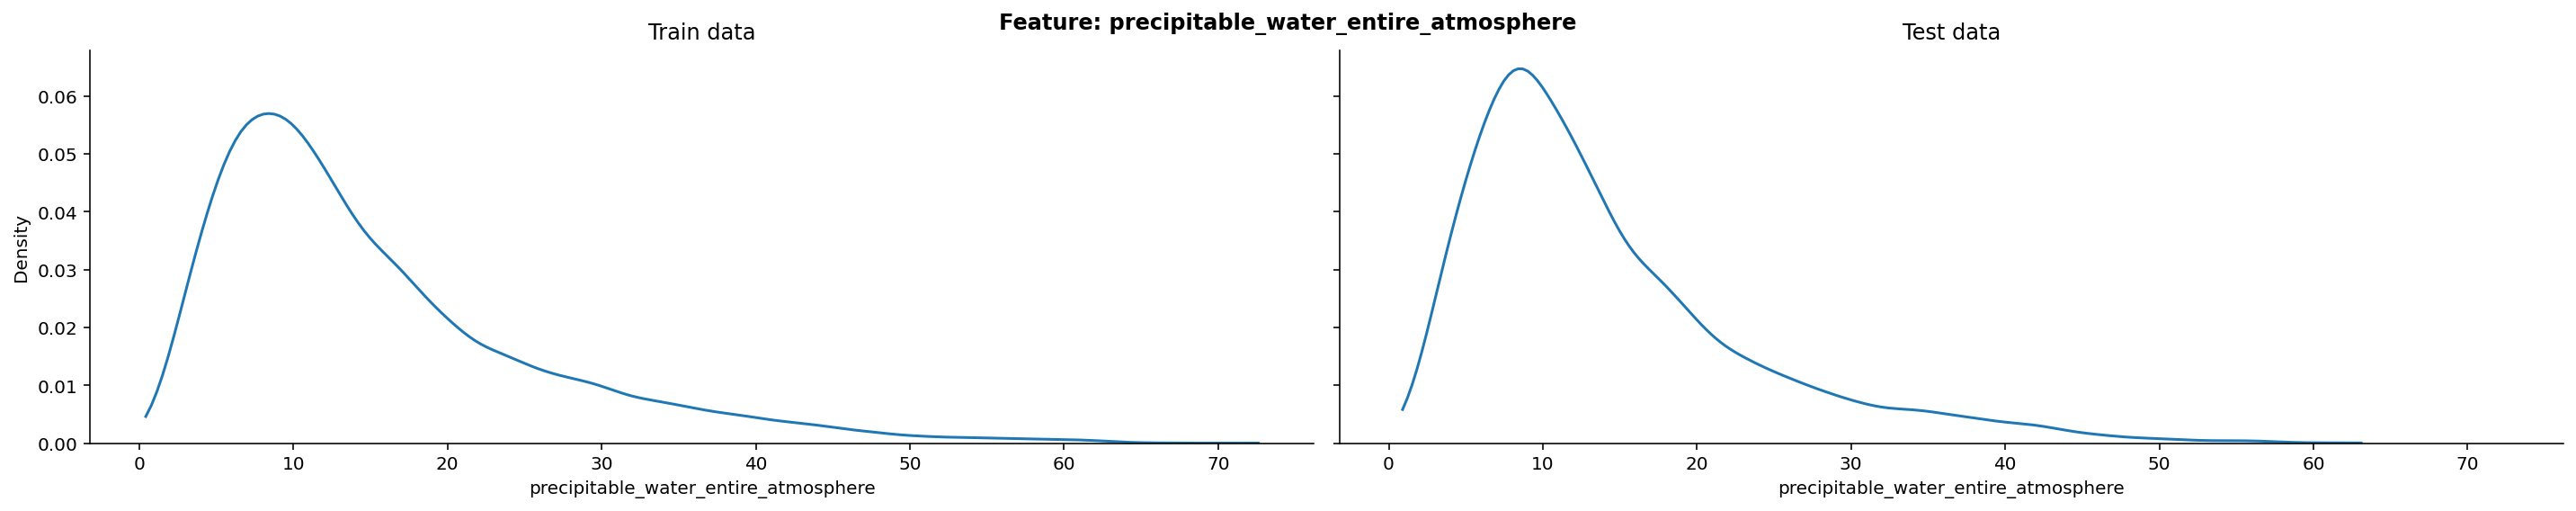

In [195]:
plot_cont('precipitable_water_entire_atmosphere')

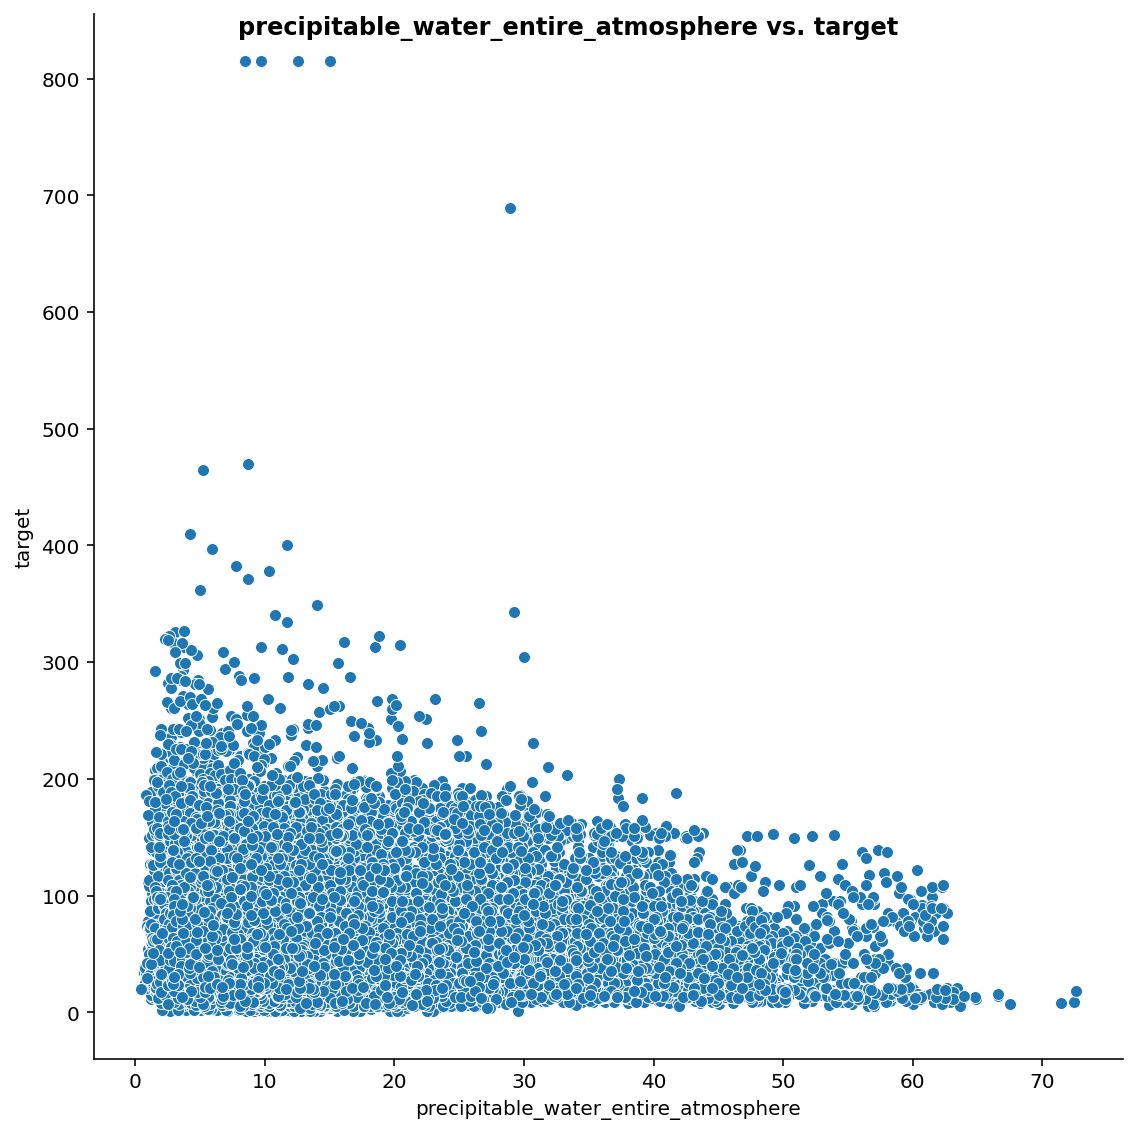

In [196]:
plot_cont_vs_target('precipitable_water_entire_atmosphere')

### relative_humidity_2m_above_ground

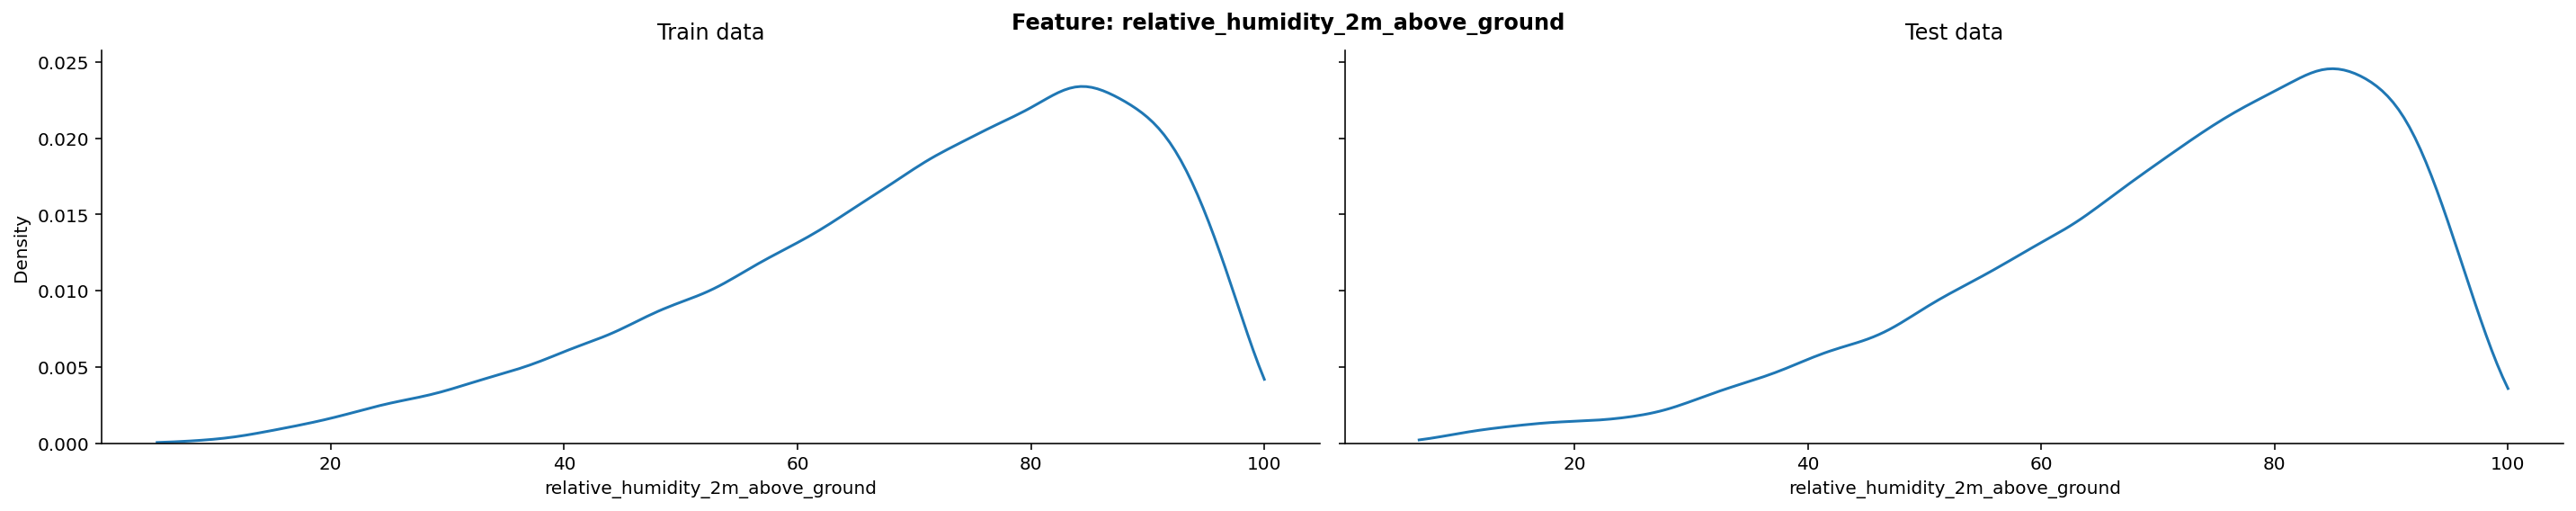

In [197]:
plot_cont('relative_humidity_2m_above_ground')

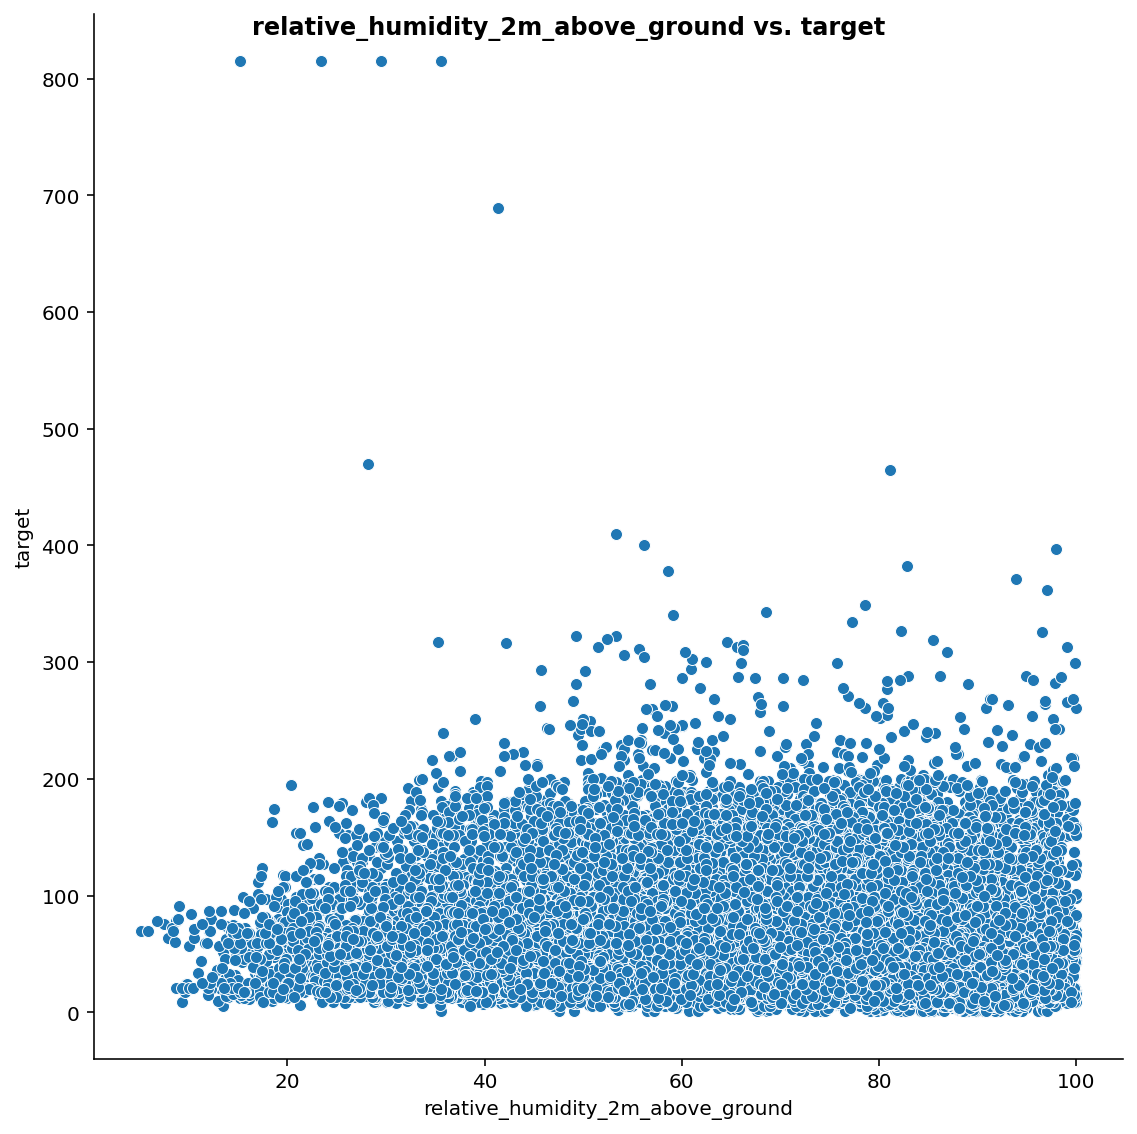

In [198]:
plot_cont_vs_target('relative_humidity_2m_above_ground')

### specific_humidity_2m_above_ground

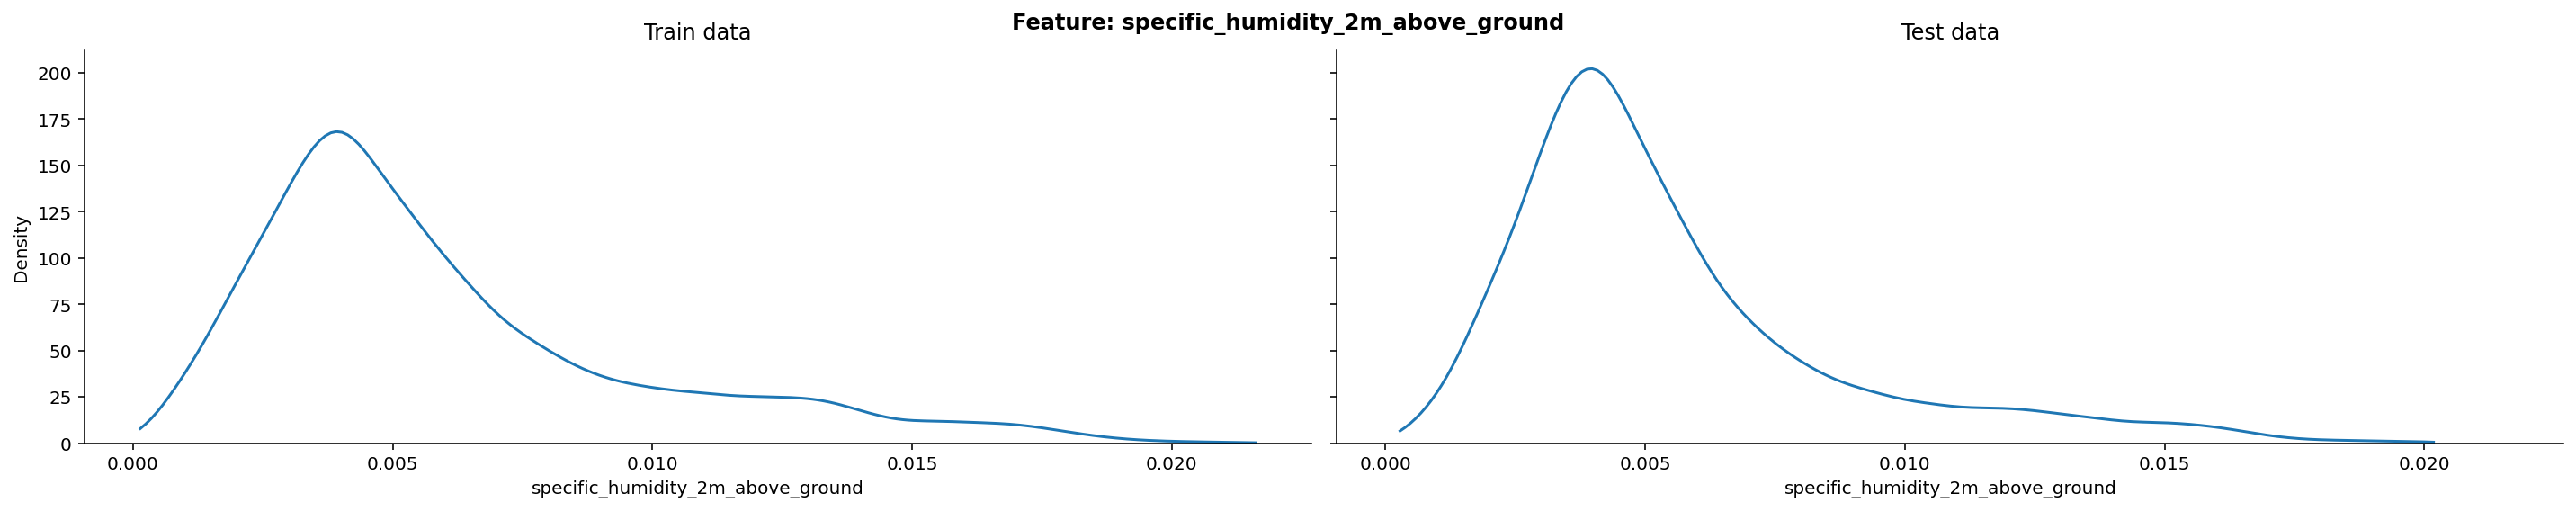

In [199]:
plot_cont('specific_humidity_2m_above_ground')

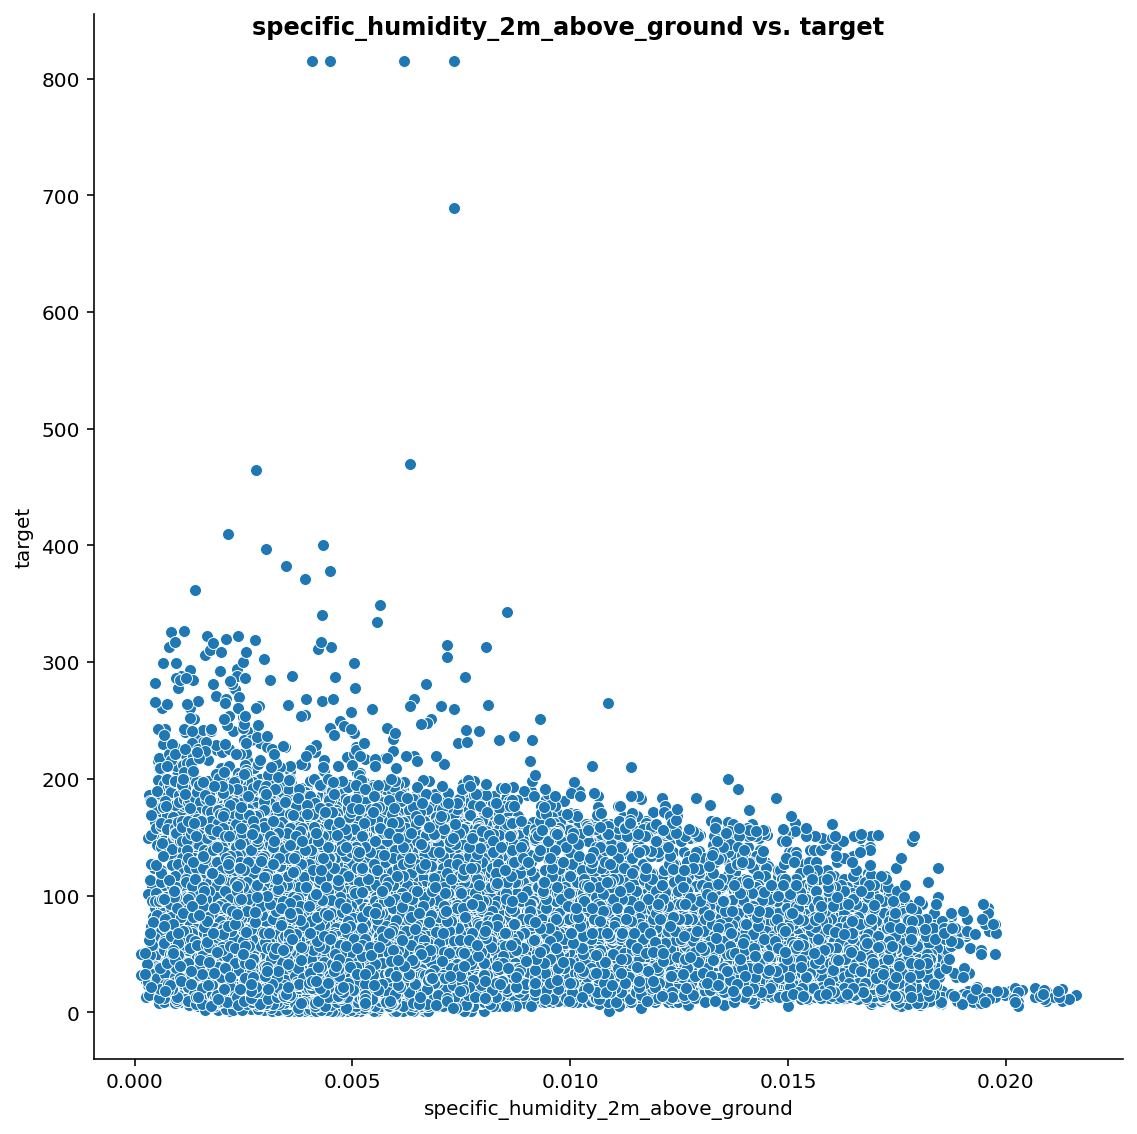

In [200]:
plot_cont_vs_target('specific_humidity_2m_above_ground')

In [201]:
train['specific_humidity_2m_above_ground'].corr(train['relative_humidity_2m_above_ground'])

0.21950909499881505

### temperature_2m_above_ground

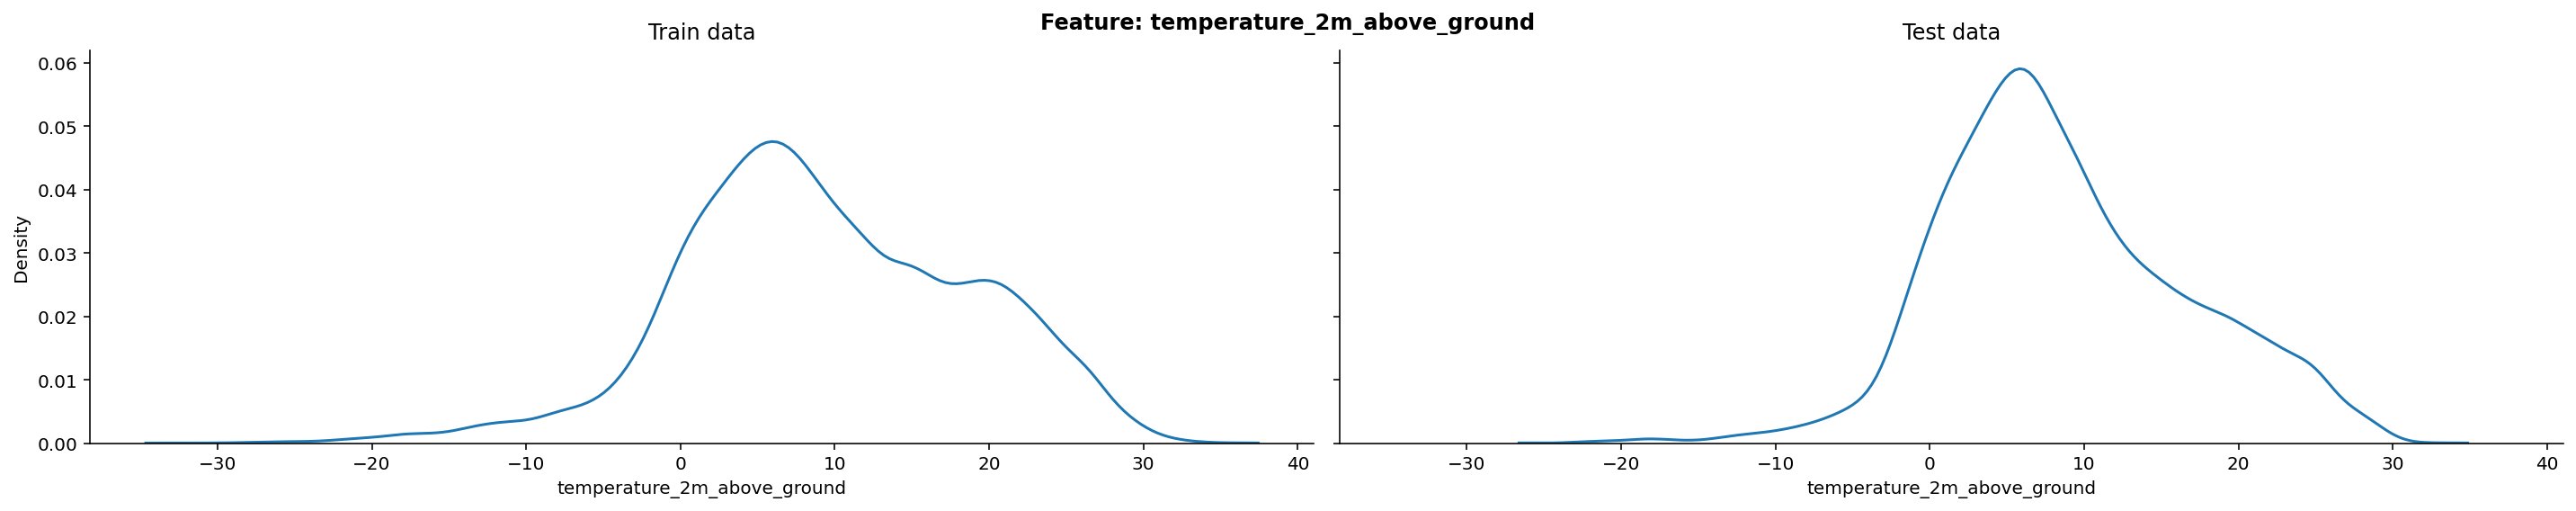

In [202]:
plot_cont('temperature_2m_above_ground')

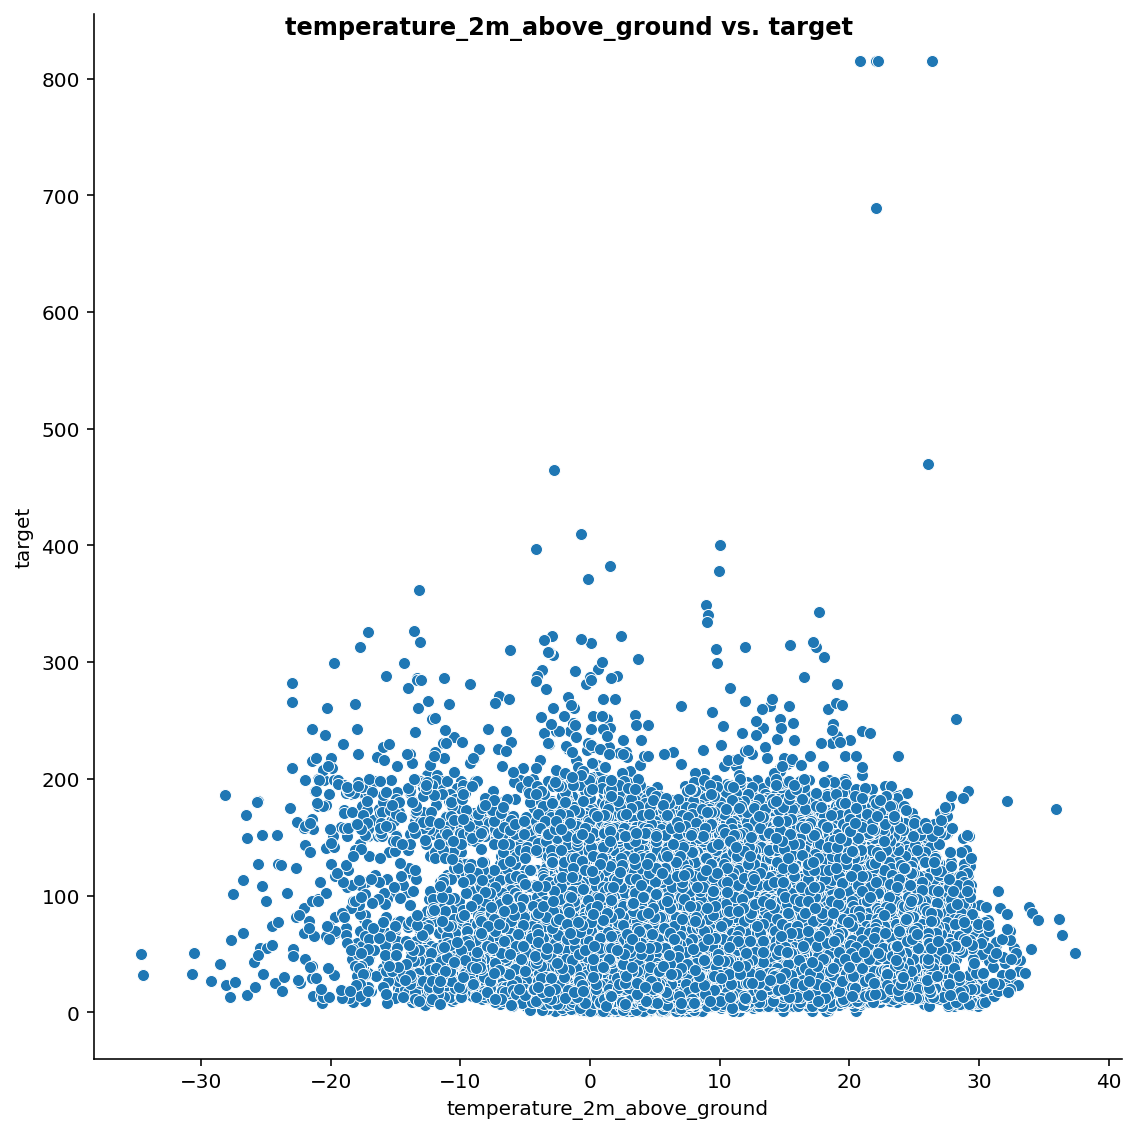

In [203]:
plot_cont_vs_target('temperature_2m_above_ground')

### u_component_of_wind_10m_above_ground

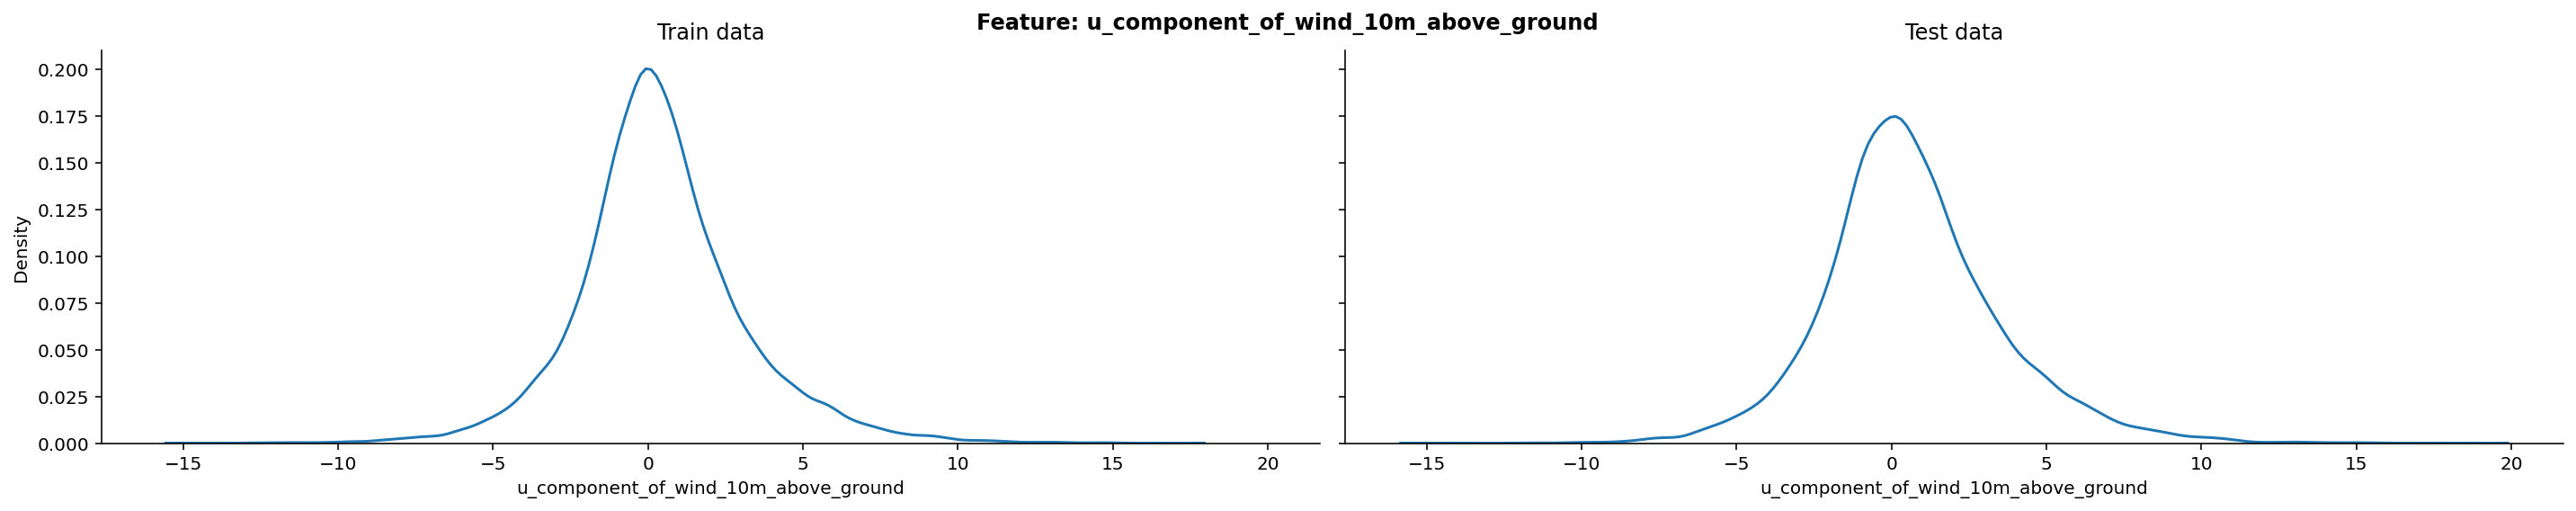

In [204]:
plot_cont('u_component_of_wind_10m_above_ground')

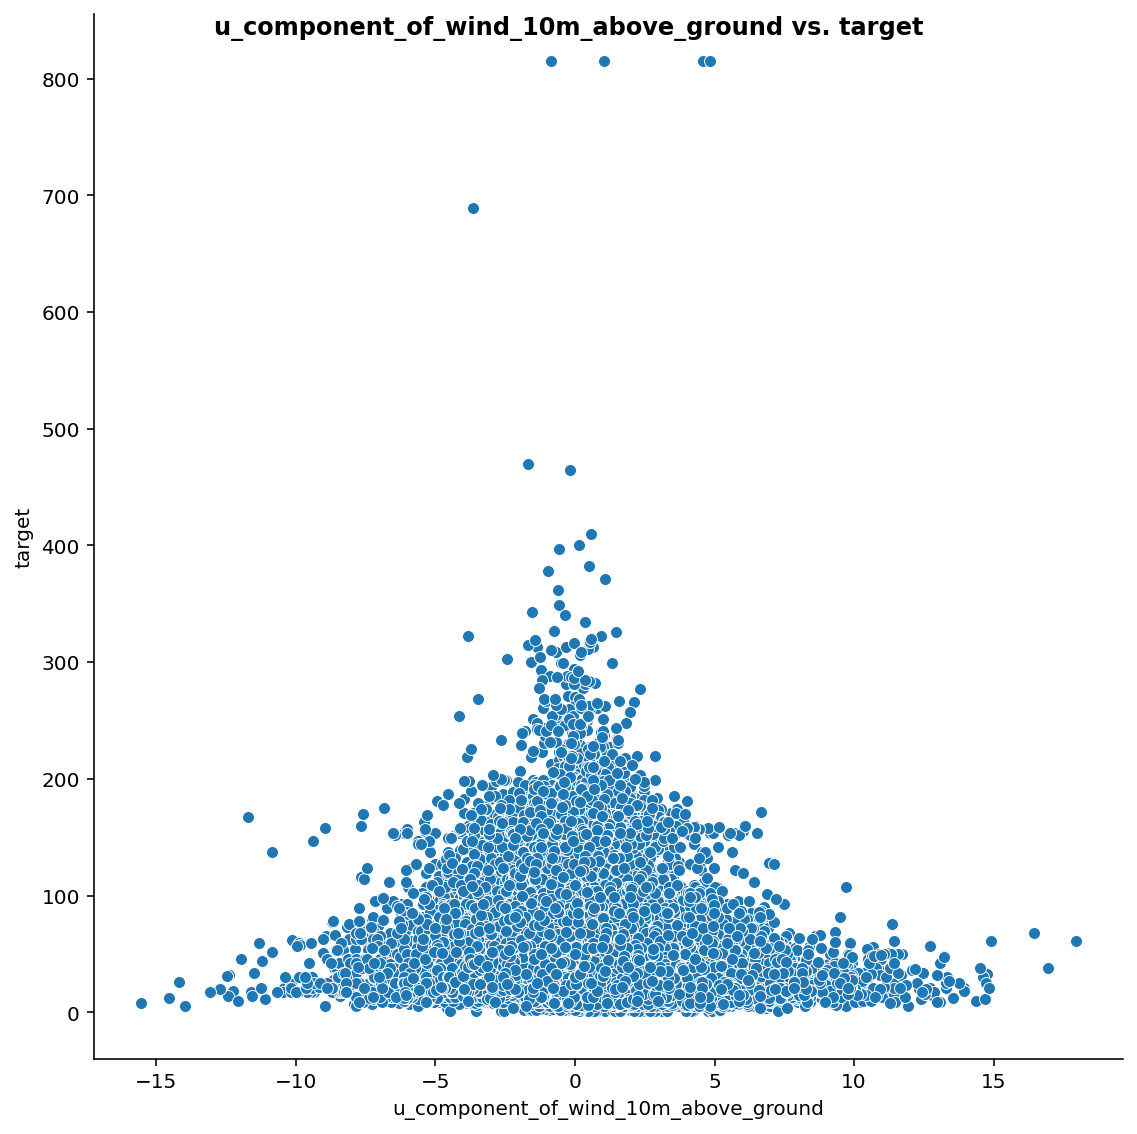

In [205]:
plot_cont_vs_target('u_component_of_wind_10m_above_ground')

### v_component_of_wind_10m_above_ground

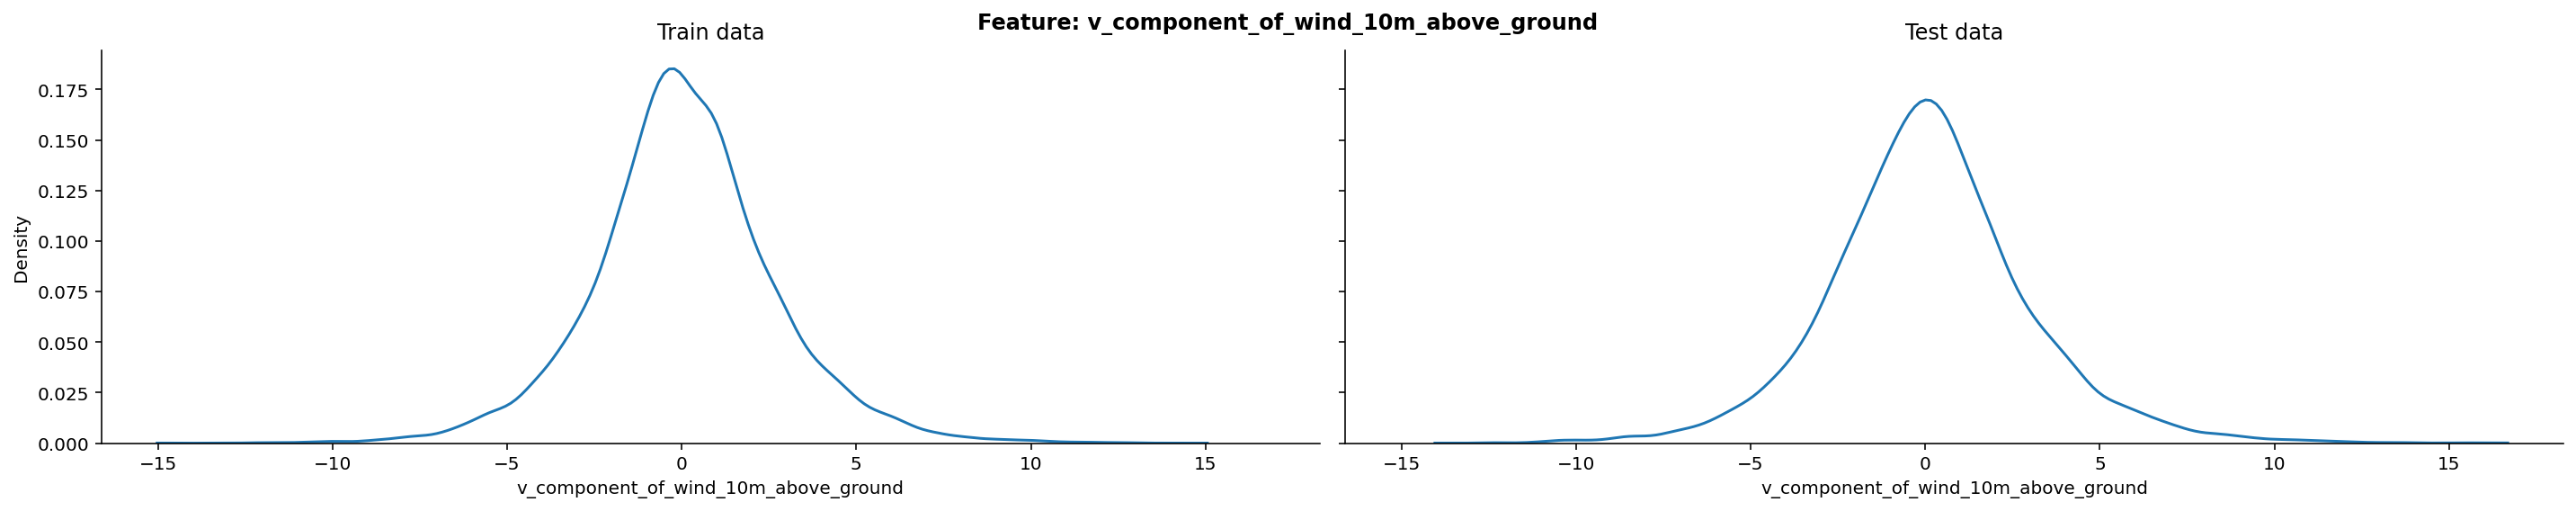

In [206]:
plot_cont('v_component_of_wind_10m_above_ground')

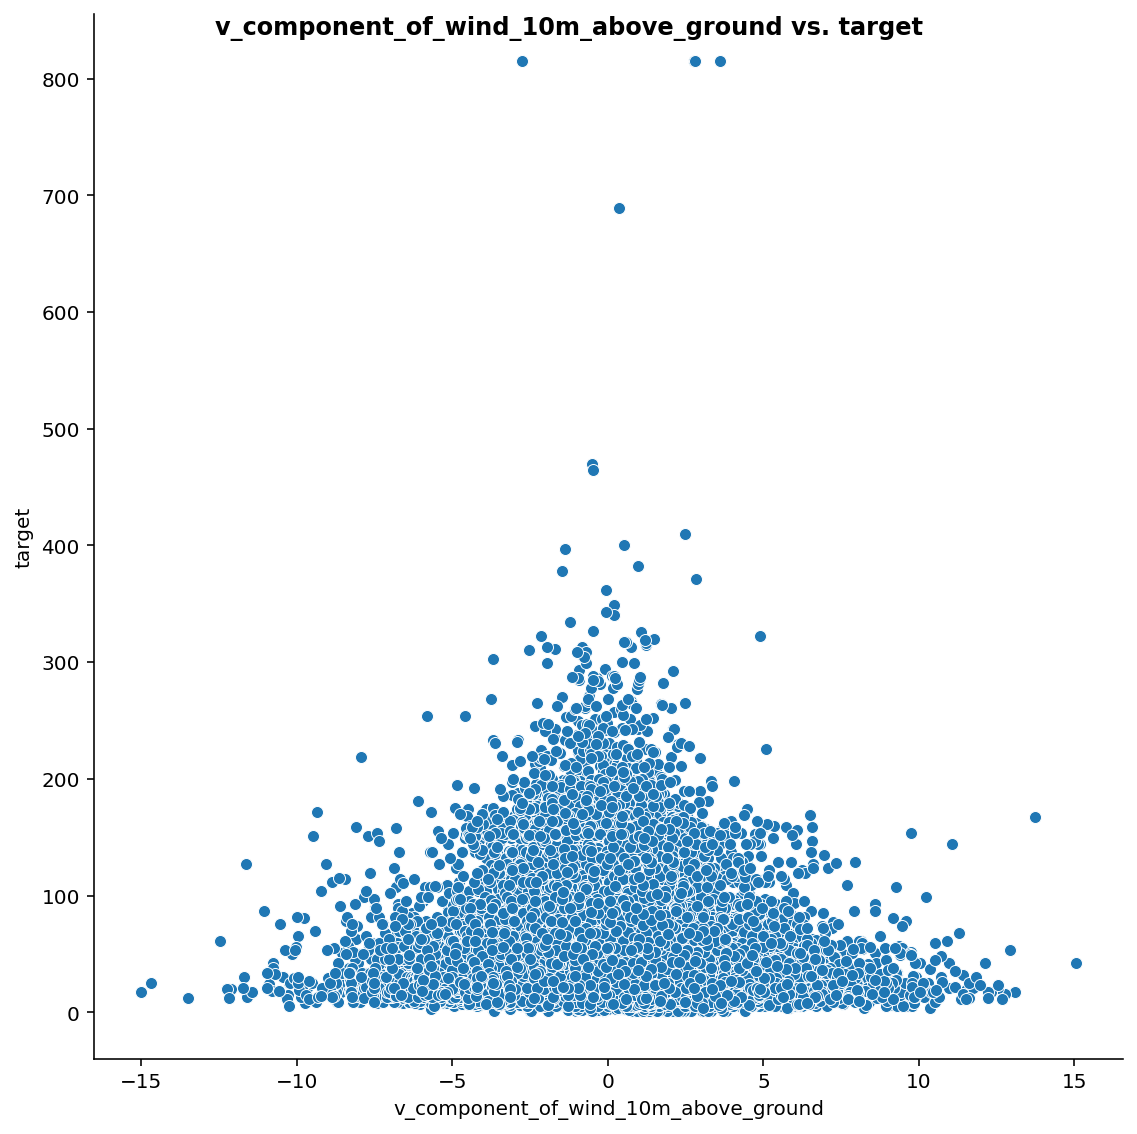

In [207]:
plot_cont_vs_target('v_component_of_wind_10m_above_ground')

# Baseline

In [208]:
reduced_features = [
                    'month', 'day', 'day_of_week', 
                    'precipitable_water_entire_atmosphere',
                    'relative_humidity_2m_above_ground', 
                    'specific_humidity_2m_above_ground', 
                    'temperature_2m_above_ground', 
                    'u_component_of_wind_10m_above_ground', 
                    'v_component_of_wind_10m_above_ground'
                   ]

all_features = [f for f in test.columns if f not in ('Place_ID X Date', 'Date', 'Place_ID')]

In [209]:
#imputation for baseline
train_imp = train.fillna(-999)
test_imp = test.fillna(-999)

In [210]:
train['Place_ID'] = train['Place_ID'].astype('category') #for GroupKFold
test['Place_ID'] = test['Place_ID'].astype('category')

In [217]:
def evaluate_model(model, features, verbose=True):
    oof_preds = {}  #out-of-fold predictions on train set
    test_preds = {} #predictions on test set for each fold
    scores_rmse = [] #RMSE scores on validation set

    X = train_imp[features]
    y = train_imp[TARGET]
    X_test = test_imp[features]

    cv = GroupKFold(n_splits=10)
    groups = np.array(train['Place_ID'])
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        oof_preds.update(dict(zip(val_idx, val_preds)))
        test_preds[f'fold{fold}'] = model.predict(X_test)

        score = mean_squared_error(y_val, val_preds, squared=False)
        scores_rmse.append(score)
        if verbose:
            print(f'Fold #{fold}: RMSE = {score:.5f}')
        
        _ = gc.collect()

    print(f'\nAvg RMSE = {np.mean(scores_rmse):.5f} +/- {np.std(scores_rmse):.5f}')
    
    oof_preds = pd.Series(oof_preds).sort_index()
    print(f'OOF RMSE = {mean_squared_error(y, oof_preds, squared=False):.5f}')
    test_preds = pd.DataFrame.from_dict(test_preds)
    return oof_preds, test_preds

In [218]:
%%time
model_1 = RandomForestRegressor()
oof_preds_1, test_preds_1 = evaluate_model(model_1, reduced_features)

Fold #0: RMSE = 44.61106
Fold #1: RMSE = 44.43199
Fold #2: RMSE = 35.76417
Fold #3: RMSE = 40.79867
Fold #4: RMSE = 52.59247
Fold #5: RMSE = 46.89622
Fold #6: RMSE = 36.48916
Fold #7: RMSE = 40.39378
Fold #8: RMSE = 37.35589
Fold #9: RMSE = 32.95684

Avg RMSE = 41.22902 +/- 5.65320
OOF RMSE = 41.61704
CPU times: user 3min 49s, sys: 345 ms, total: 3min 49s
Wall time: 3min 49s


In [219]:
%%time
model_2 = RandomForestRegressor()
oof_preds_2, test_preds_2 = evaluate_model(model_2, all_features)

Fold #0: RMSE = 36.02419
Fold #1: RMSE = 31.52534
Fold #2: RMSE = 28.87974
Fold #3: RMSE = 37.46206
Fold #4: RMSE = 43.83509
Fold #5: RMSE = 34.48875
Fold #6: RMSE = 31.89331
Fold #7: RMSE = 29.62409
Fold #8: RMSE = 30.02625
Fold #9: RMSE = 26.60885

Avg RMSE = 33.03677 +/- 4.79709
OOF RMSE = 33.38953
CPU times: user 31min 55s, sys: 2 s, total: 31min 57s
Wall time: 31min 50s


In [220]:
def create_submission_files(
        predictions_df,
        model_number, 
        feature_set,  
        path=SUBMISSION_PATH):
    
    file_path = f'{path}/m_{model_number}'
    if not os.path.isdir(file_path):
        os.mkdir(file_path)

    for col in (predictions_df.columns):
        sub = pd.DataFrame({'Place_ID X Date': TEST_INDEX,'target': predictions_df[col]})
        sub.to_csv(f'{file_path}/{feature_set}_{col}.csv', index=False)

    sub = pd.DataFrame({'Place_ID X Date': TEST_INDEX,'target': predictions_df.mean(axis=1)})
    sub.to_csv(f'{file_path}/{feature_set}_mean.csv', index=False)

In [223]:
create_submission_files(test_preds_1, model_number='01', feature_set='reduced')

In [224]:
create_submission_files(test_preds_2, model_number='02', feature_set='all')